# Install and Import Required Libraries

## Install

In [ ]:
!pip install hazm
!pip install stanfordnlp
!pip install -U nltk
!pip install pandas
!pip install sklearn
!pip install numpy

Processing /root/.cache/pip/wheels/d1/ab/40/3bceea46922767e42986aef7606a600538ca80de6062dc266c/nltk-3.3-cp36-none-any.whl
  Found existing installation: nltk 3.5
    Uninstalling nltk-3.5:
      Successfully uninstalled nltk-3.5


Processing /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306/nltk-3.5-cp36-none-any.whl
ERROR: hazm 0.7.0 has requirement nltk==3.3, but you'll have nltk 3.5 which is incompatible.
  Found existing installation: nltk 3.3
    Uninstalling nltk-3.3:
      Successfully uninstalled nltk-3.3


## Import

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
import stanfordnlp
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

import os.path
import joblib

# Import my class from google drive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

FeatureExtractor = drive.CreateFile({'id':'1IwEfIW-lYHvGSSr6TwMsGX3xX1Z829cP'})
FeatureExtractor.GetContentFile('psfeatureextractor.py')
from psfeatureextractor import PSFeatureExtractor as FeatureExtractor

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Common Functions and Variables

In [ ]:
stanford_models_path  = '/content/drive/My Drive/Stance Detection Paper/persian_stance_baseline_data/' 
dataset_path = '/content/drive/My Drive/Stance Detection Paper/HeadlineToClaim.csv'
stopWord_path = '/content/drive/My Drive/ImportantNLPFiles/StopWords_fa.txt'
polarity_dataset_path = '/content/drive/My Drive/Stance Detection Paper/PolarityDataset.xlsx'
save_load_path = "/content/drive/My Drive/Stance Detection Paper/persian_stance_baseline_data/vectors"
w2v_model_path = "/content/drive/My Drive/Stance Detection Paper/persian_stance_baseline_data/vectors/w2v_persian.pkl"
train_test_sets_save_path = "/content/drive/My Drive/Stance Detection Paper/persian_stance_baseline_data"
train_test_sets_load_path = "/content/drive/My Drive/Stance Detection Paper/persian_stance_baseline_data"

## k_fold_train_test function

In [ ]:
def k_fold_train_test(X, Y, k_fold, model, scoring = 'accuracy' , additional_description = ''):
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X, Y, scoring = scoring, cv= k_fold)
  result = []
  df_result = pd.DataFrame(index=range(k_fold))
  for fold_index, accuracy in enumerate(accuracies):
    result.append((model_name, fold_index, accuracy))
  
  df_result = pd.DataFrame(result, columns=['model_name', 'fold_index', scoring])

  sns.boxplot(x = 'model_name', y = scoring, data = df_result)
  sns.stripplot(x='model_name', y=scoring, data = df_result, 
                size=8, jitter=True, edgecolor="gray", linewidth=2)
  plt.show()

  print('Mean '+scoring + ' of ' + model_name + ' in ' + str(k_fold) + ' fold is: ', np.average(accuracies, axis=0))
  if len(additional_description)>0:
    print(additional_description)
  return df_result

## common_train_test function

In [ ]:
def common_train_test(model, X, Y, test_size= 0.2
,save_datasets = True, save_path = '', load_if_exist = True, load_path = '', additional_description = ''
, features_name= ''):
  
  model_name = model.__class__.__name__
  file_not_exist = False
  if load_if_exist :
    assert len(load_path) > 0, "Please enter load_path."
    load_X_train = load_path + '/X_train_'+features_name+'.pkl'
    load_X_test = load_path + '/X_test_'+features_name+'.pkl'
    load_y_train = load_path + '/y_train_'+features_name+'.pkl'
    load_y_test = load_path + '/y_test_'+features_name+'.pkl'
    if os.path.isfile(load_X_train) == True :
      X_train = joblib.load(load_X_train)
      print('X_train loaded successfully.')
    else:
      print('X_train file is not exist.')
      file_not_exist = True
    if os.path.isfile(load_X_test) == True :
      X_test = joblib.load(load_X_test)
      print('X_test loaded successfully.')
    else:
      print('X_test file is not exist.')  
      file_not_exist = True
    if os.path.isfile(load_y_train) == True :
      y_train = joblib.load(load_y_train)
      print('y_train loaded successfully.')
    else:
      print('y_train file is not exist.') 
      file_not_exist = True
    if os.path.isfile(load_y_test) == True :
      y_test = joblib.load(load_y_test)
      print('y_test loaded successfully.')
    else:
      print('y_test file is not exist.')
      file_not_exist = True
  if load_if_exist == False or file_not_exist == True:
    X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle= True , test_size = test_size, random_state = 0)
    print('Train and test sets created successfully.')
    if save_datasets:
      joblib.dump(X_train,load_path + '/X_train_'+features_name+'.pkl')
      joblib.dump(X_test,load_path + '/X_test_'+features_name+'.pkl')
      joblib.dump(y_train,load_path + '/y_train_'+features_name+'.pkl')
      joblib.dump(y_test,load_path + '/y_test_'+features_name+'.pkl')
      print('Train and test sets saved successfully.')
  else:
    print('Train and test sets loaded successfully.')

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  conf_mat = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots(figsize=(4,4))
  labels_name = np.unique(Y)
  sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels = labels_name, yticklabels = labels_name)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  print(model_name)
  plt.show()

  print(metrics.classification_report(y_test, y_pred, labels_name))
  print('accuracy : ', accuracy_score(y_test, y_pred))
  print('weighted f1 score : ', f1_score(y_test, y_pred, average='weighted'))
  if len(additional_description)>0:
    print(additional_description)
  return y_pred

## Create Feature Extractor Object

In [ ]:
psf_extractor = FeatureExtractor(dataset_path = dataset_path, stopWord_path = stopWord_path
                                    , polarity_dataset_path = polarity_dataset_path,
                                  stanford_models_path = stanford_models_path
                                  ,use_google_drive = True, important_words = ['؟',
             'تکذیب',
             'تکذیب شد',
             ':',
             ])

tokens_claims , tokens_headlines = psf_extractor.nltk_tokenize()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/ImportantNLPFiles/StopWords_fa.txt
(2029,) (2029,) (2029,) (2029,) (2029,)


In [ ]:
labels = np.reshape(psf_extractor.labels,(len(psf_extractor.labels),1))
labels.shape

In [ ]:
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

# TF-IDF With Other Features

## Extract Feature

In [ ]:
features, features_name = psf_extractor.generate_Features(w2v_model_path = w2v_model_path,save_path = save_load_path
                                                          , save_feature= True
                                                          , load_path= save_load_path
                                                          , load_if_exist = True, bow = False, w2v = False, polarity= False)

features.shape

Features loaded successfully.


(2029, 728)

## Train Best Models

### *SVM*

X_train file is not exist.
X_test file is not exist.
y_train file is not exist.
y_test file is not exist.
Train and test sets created successfully.
Train and test sets saved successfully.
SVC


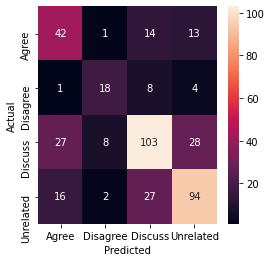

              precision    recall  f1-score   support

       Agree       0.49      0.60      0.54        70
    Disagree       0.62      0.58      0.60        31
     Discuss       0.68      0.62      0.65       166
   Unrelated       0.68      0.68      0.68       139

    accuracy                           0.63       406
   macro avg       0.62      0.62      0.62       406
weighted avg       0.64      0.63      0.64       406

accuracy :  0.6330049261083743
weighted f1 score :  0.6350416228750646
With the features : tfidf_similarity_important_words_more_than2_parts_root_distance_


In [ ]:
model = SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
result = common_train_test(model = model, X=features, Y=labels, test_size = 0.2
                           , additional_description = 'With the features : '+ features_name
                           , save_datasets = True, save_path = train_test_sets_save_path
                           , load_if_exist = True, load_path = train_test_sets_load_path
                           , features_name = features_name)

### RandomForestClassifier

X_train loaded successfully.
X_test loaded successfully.
y_train loaded successfully.
y_test loaded successfully.
Train and test sets loaded successfully.
RandomForestClassifier


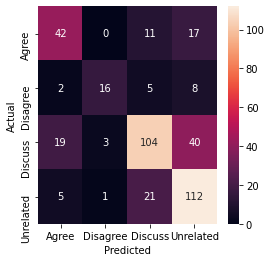

              precision    recall  f1-score   support

       Agree       0.62      0.60      0.61        70
    Disagree       0.80      0.52      0.63        31
     Discuss       0.74      0.63      0.68       166
   Unrelated       0.63      0.81      0.71       139

    accuracy                           0.67       406
   macro avg       0.70      0.64      0.66       406
weighted avg       0.69      0.67      0.67       406

accuracy :  0.6748768472906403
weighted f1 score :  0.6725625048978913
With the features : tfidf_similarity_important_words_more_than2_parts_root_distance_


In [ ]:
model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=75, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)      
result = common_train_test(model = model, X=features, Y=labels, test_size = 0.2
                           , additional_description = 'With the features : '+ features_name
                           , save_datasets = True, save_path = train_test_sets_save_path
                           , load_if_exist = True, load_path = train_test_sets_load_path
                           , features_name = features_name)

### Linear SVC

X_train loaded successfully.
X_test loaded successfully.
y_train loaded successfully.
y_test loaded successfully.
Train and test sets loaded successfully.
LinearSVC


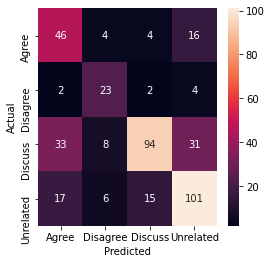

              precision    recall  f1-score   support

       Agree       0.47      0.66      0.55        70
    Disagree       0.56      0.74      0.64        31
     Discuss       0.82      0.57      0.67       166
   Unrelated       0.66      0.73      0.69       139

    accuracy                           0.65       406
   macro avg       0.63      0.67      0.64       406
weighted avg       0.69      0.65      0.65       406

accuracy :  0.6502463054187192
weighted f1 score :  0.6544023635914299
With the features : tfidf_similarity_important_words_more_than2_parts_root_distance_


In [ ]:
model = LinearSVC(C=0.5, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)
result = common_train_test(model = model, X=features, Y=labels, test_size = 0.2
                           , additional_description = 'With the features : '+ features_name
                           , save_datasets = True, save_path = train_test_sets_save_path
                           , load_if_exist = True, load_path = train_test_sets_load_path
                           , features_name = features_name)

### Logistic Regression

X_train loaded successfully.
X_test loaded successfully.
y_train loaded successfully.
y_test loaded successfully.
Train and test sets loaded successfully.
LogisticRegression


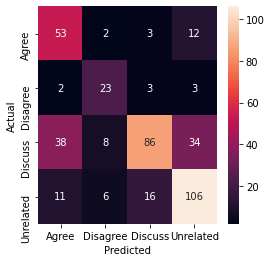

              precision    recall  f1-score   support

       Agree       0.51      0.76      0.61        70
    Disagree       0.59      0.74      0.66        31
     Discuss       0.80      0.52      0.63       166
   Unrelated       0.68      0.76      0.72       139

    accuracy                           0.66       406
   macro avg       0.64      0.69      0.65       406
weighted avg       0.69      0.66      0.66       406

accuracy :  0.6600985221674877
weighted f1 score :  0.6587457606192086
With the features : tfidf_similarity_important_words_more_than2_parts_root_distance_


In [ ]:
# with "l1_ratio": ['None']
model = LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='ovr', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
result = common_train_test(model = model, X=features, Y=labels, test_size = 0.2
                           , additional_description = 'With the features : '+ features_name
                           , save_datasets = True, save_path = train_test_sets_save_path
                           , load_if_exist = True, load_path = train_test_sets_load_path
                           , features_name = features_name)

X_train loaded successfully.
X_test loaded successfully.
y_train loaded successfully.
y_test loaded successfully.
Train and test sets loaded successfully.
LogisticRegression


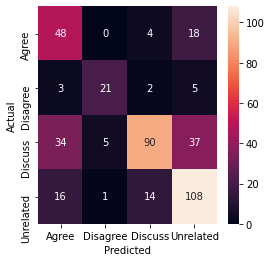

              precision    recall  f1-score   support

       Agree       0.48      0.69      0.56        70
    Disagree       0.78      0.68      0.72        31
     Discuss       0.82      0.54      0.65       166
   Unrelated       0.64      0.78      0.70       139

    accuracy                           0.66       406
   macro avg       0.68      0.67      0.66       406
weighted avg       0.70      0.66      0.66       406

accuracy :  0.6576354679802956
weighted f1 score :  0.6596193020786388
With the features : tfidf_similarity_important_words_more_than2_parts_root_distance_


In [ ]:
# with "l1_ratio": [0.1]
model = LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.1, max_iter=1000,
                   multi_class='ovr', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
result = common_train_test(model = model, X=features, Y=labels, test_size = 0.2
                           , additional_description = 'With the features : '+ features_name
                           , save_datasets = True, save_path = train_test_sets_save_path
                           , load_if_exist = True, load_path = train_test_sets_load_path
                           , features_name = features_name)

X_train loaded successfully.
X_test loaded successfully.
y_train loaded successfully.
y_test loaded successfully.
Train and test sets loaded successfully.
LogisticRegression


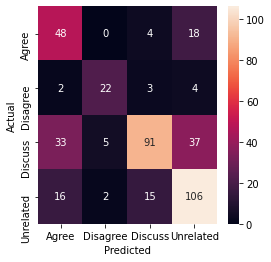

              precision    recall  f1-score   support

       Agree       0.48      0.69      0.57        70
    Disagree       0.76      0.71      0.73        31
     Discuss       0.81      0.55      0.65       166
   Unrelated       0.64      0.76      0.70       139

    accuracy                           0.66       406
   macro avg       0.67      0.68      0.66       406
weighted avg       0.69      0.66      0.66       406

accuracy :  0.6576354679802956
weighted f1 score :  0.659402945370372
With the features : tfidf_similarity_important_words_more_than2_parts_root_distance_


In [ ]:
# with "l1_ratio": [0.2]
model = LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.2, max_iter=1000,
                   multi_class='ovr', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
result = common_train_test(model = model, X=features, Y=labels, test_size = 0.2
                           , additional_description = 'With the features : '+ features_name
                           , save_datasets = True, save_path = train_test_sets_save_path
                           , load_if_exist = True, load_path = train_test_sets_load_path
                           , features_name = features_name)

X_train loaded successfully.
X_test loaded successfully.
y_train loaded successfully.
y_test loaded successfully.
Train and test sets loaded successfully.
LogisticRegression


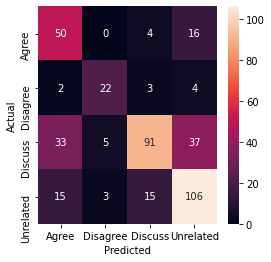

              precision    recall  f1-score   support

       Agree       0.50      0.71      0.59        70
    Disagree       0.73      0.71      0.72        31
     Discuss       0.81      0.55      0.65       166
   Unrelated       0.65      0.76      0.70       139

    accuracy                           0.66       406
   macro avg       0.67      0.68      0.67       406
weighted avg       0.69      0.66      0.66       406

accuracy :  0.6625615763546798
weighted f1 score :  0.6635468562009657
With the features : tfidf_similarity_important_words_more_than2_parts_root_distance_


In [ ]:
# with "l1_ratio": [0.3]
model = LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.3, max_iter=1000,
                   multi_class='ovr', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
result = common_train_test(model = model, X=features, Y=labels, test_size = 0.2
                           , additional_description = 'With the features : '+ features_name
                           , save_datasets = True, save_path = train_test_sets_save_path
                           , load_if_exist = True, load_path = train_test_sets_load_path
                           , features_name = features_name)

### Gussian Naive Bays

X_train loaded successfully.
X_test loaded successfully.
y_train loaded successfully.
y_test loaded successfully.
Train and test sets loaded successfully.
GaussianNB


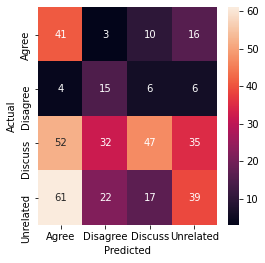

              precision    recall  f1-score   support

       Agree       0.26      0.59      0.36        70
    Disagree       0.21      0.48      0.29        31
     Discuss       0.59      0.28      0.38       166
   Unrelated       0.41      0.28      0.33       139

    accuracy                           0.35       406
   macro avg       0.37      0.41      0.34       406
weighted avg       0.44      0.35      0.35       406

accuracy :  0.3497536945812808
weighted f1 score :  0.3541173136251047
With the features : tfidf_similarity_important_words_more_than2_parts_root_distance_


In [ ]:
model = GaussianNB()
result = common_train_test(model = model, X=features, Y=labels, test_size = 0.2
                           , additional_description = 'With the features : '+ features_name
                           , save_datasets = True, save_path = train_test_sets_save_path
                           , load_if_exist = True, load_path = train_test_sets_load_path
                           , features_name = features_name)

## With 10 Fold Cross Validation

## SVM

In [ ]:
model = SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
df_result = k_fold_train_test(X=features, Y=labels, k_fold = 10, model=model , scoring = 'accuracy'
, additional_description = 'With the features : '+ features_name)

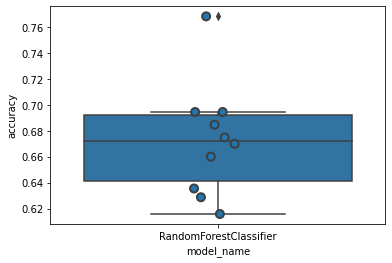

Mean accuracy of RandomForestClassifier in 10 fold is:  0.6727235038774814
With the features : tfidf_similarity_important_words_more_than2_parts_root_distance_polarity_


In [ ]:
features, labels = shuffle(features, labels, random_state=0)
model = RandomForestClassifier(n_estimators=100, random_state=0)
df_result = k_fold_train_test(X=features, Y=labels, k_fold = 10, model=model , scoring = 'accuracy'
, additional_description = 'With the features : '+ features_name)

# BOW With Other Features

## Extract Feature

In [ ]:
features, features_name = psf_extractor.generate_Features(w2v_model_path = w2v_model_path,save_path = save_load_path
                                                          , save_feature= True
                                                          , load_path= save_load_path
                                                          , load_if_exist = True, tfidf = False, w2v = False, polarity= False)

features.shape

Features vector file is not exist.
Start to generate similarity feature
End of similarity feature
Start to generate important words feature
End of important words feature
"is question" feature was added.
"more than tow parts" feature was added.
Start to generate root distance feature
Use device: gpu
---
Loading: tokenize
With settings: 
{'model_path': '/content/drive/My Drive/Stance Detection Paper/persian_stance_baseline_data/fa_seraji_models/fa_seraji_tokenizer.pt', 'lang': 'fa', 'shorthand': 'fa_seraji', 'mode': 'predict'}
---
Loading: mwt
With settings: 
{'model_path': '/content/drive/My Drive/Stance Detection Paper/persian_stance_baseline_data/fa_seraji_models/fa_seraji_mwt_expander.pt', 'lang': 'fa', 'shorthand': 'fa_seraji', 'mode': 'predict'}
Building an attentional Seq2Seq model...
Using a Bi-LSTM encoder
Using soft attention for LSTM.
Finetune all embeddings.
---
Loading: pos
With settings: 
{'model_path': '/content/drive/My Drive/Stance Detection Paper/persian_stance_baselin

(2029, 20360)

## Train Best Models

### SVM

X_train file is not exist.
X_test file is not exist.
y_train file is not exist.
y_test file is not exist.
Train and test sets created successfully.
Train and test sets saved successfully.
SVC


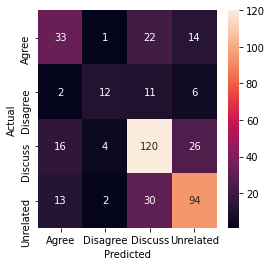

              precision    recall  f1-score   support

       Agree       0.52      0.47      0.49        70
    Disagree       0.63      0.39      0.48        31
     Discuss       0.66      0.72      0.69       166
   Unrelated       0.67      0.68      0.67       139

    accuracy                           0.64       406
   macro avg       0.62      0.56      0.58       406
weighted avg       0.64      0.64      0.63       406

accuracy :  0.6379310344827587
weighted f1 score :  0.6334370004218493
With the features : similarity_important_words_more_than2_parts_root_distance_bow_


In [ ]:
model = SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
result = common_train_test(model = model, X=features, Y=labels, test_size = 0.2
                           , additional_description = 'With the features : '+ features_name
                           , save_datasets = True, save_path = train_test_sets_save_path
                           , load_if_exist = True, load_path = train_test_sets_load_path
                           , features_name = features_name)

### RandomForestClassifier

X_train loaded successfully.
X_test loaded successfully.
y_train loaded successfully.
y_test loaded successfully.
Train and test sets loaded successfully.
RandomForestClassifier


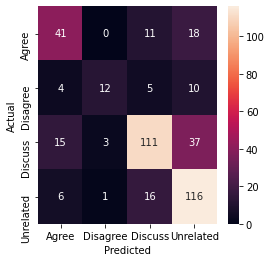

              precision    recall  f1-score   support

       Agree       0.62      0.59      0.60        70
    Disagree       0.75      0.39      0.51        31
     Discuss       0.78      0.67      0.72       166
   Unrelated       0.64      0.83      0.72       139

    accuracy                           0.69       406
   macro avg       0.70      0.62      0.64       406
weighted avg       0.70      0.69      0.68       406

accuracy :  0.6896551724137931
weighted f1 score :  0.6849083879539749
With the features : similarity_important_words_more_than2_parts_root_distance_bow_


In [ ]:
model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=75, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)      
result = common_train_test(model = model, X=features, Y=labels, test_size = 0.2
                           , additional_description = 'With the features : '+ features_name
                           , save_datasets = True, save_path = train_test_sets_save_path
                           , load_if_exist = True, load_path = train_test_sets_load_path
                           , features_name = features_name)

### Linear SVC

X_train loaded successfully.
X_test loaded successfully.
y_train loaded successfully.
y_test loaded successfully.
Train and test sets loaded successfully.
LinearSVC


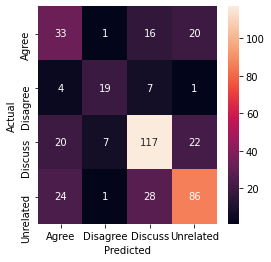

              precision    recall  f1-score   support

       Agree       0.41      0.47      0.44        70
    Disagree       0.68      0.61      0.64        31
     Discuss       0.70      0.70      0.70       166
   Unrelated       0.67      0.62      0.64       139

    accuracy                           0.63       406
   macro avg       0.61      0.60      0.61       406
weighted avg       0.64      0.63      0.63       406

accuracy :  0.6280788177339901
weighted f1 score :  0.630715479326273
With the features : similarity_important_words_more_than2_parts_root_distance_bow_


In [ ]:
model = LinearSVC(C=1, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1200,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
result = common_train_test(model = model, X=features, Y=labels, test_size = 0.2
                           , additional_description = 'With the features : '+ features_name
                           , save_datasets = True, save_path = train_test_sets_save_path
                           , load_if_exist = True, load_path = train_test_sets_load_path
                           , features_name = features_name)

### Logistic Regression

In [ ]:
# with "l1_ratio": ['None']
model = LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='ovr', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False, l1_ratio= 0.1)
result = common_train_test(model = model, X=features, Y=labels, test_size = 0.2
                           , additional_description = 'With the features : '+ features_name
                           , save_datasets = True, save_path = train_test_sets_save_path
                           , load_if_exist = True, load_path = train_test_sets_load_path
                           , features_name = features_name)

### Gussian Naive Bays

In [ ]:
model = GaussianNB()
result = common_train_test(model = model, X=features, Y=labels, test_size = 0.2
                           , additional_description = 'With the features : '+ features_name
                           , save_datasets = True, save_path = train_test_sets_save_path
                           , load_if_exist = True, load_path = train_test_sets_load_path
                           , features_name = features_name)

In [ ]:
# function ClickConnect(){
# console.log("Clicking");
# document.querySelector("colab-connect-button").click()
# }
# setInterval(ClickConnect,60000)